# Monte Carlo Markov Chain Metropolis algorithm

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import random
import matplotlib.pyplot as plt
import pdb
from matplotlib.gridspec import GridSpec

Cargamos la dataset y verificamos que los datos no tengan ningún error

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [97]:
# Datos
data = np.loadtxt('/content/drive/MyDrive/Data/olympic100m_men.txt', delimiter = ',').T
x = data[0]
y = data[1]

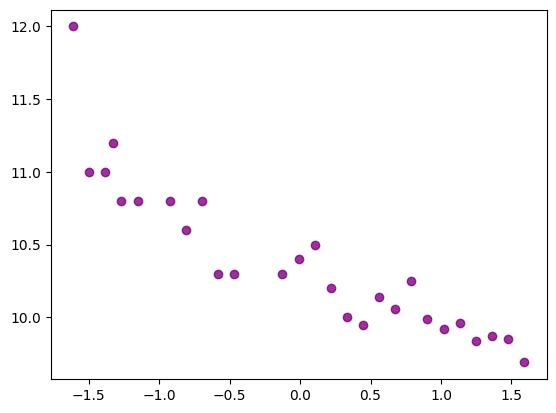

In [109]:
# Datos normalizados
x_nor = (x - np.mean(x))/(np.std(x))

plt.scatter(x_nor,y, color='purple', alpha=0.8)

Primero, definimos un modelo lineal
$$ f = w_o+w_1x $$
Con
$$ \theta = [w_0, w_1] $$

In [48]:
# Modelo lineal
def model(x, theta):
  m, b = theta
  return b + m*x

También definimos las funciones de likelihood y prior en su forma logarítmica:

Likelihood (sin tomar la parte que contempla errores):
$$ ln L \propto -\dfrac{1}{2}Σ_{i}\left(y_{i} - Model(x_{i},\vec{w})\right)^2$$

Para el Posterior tenemos:
$$lnP \propto ln L + lnPr$$
Sin embargo, no lo definiremos como función, sino que la definiremos dentro del método de MCMC

In [92]:
# Likelihood
def likelihood(x, y, theta):
  log = -1/2*np.sum((y- model(x, theta))**2)
  return log

likelihood(x,y, [.1, 31])

-629179.5647

In [101]:
# Establecemos los valores w_0 min y max, y w_1 min y max
limits = [-1.0, 1.0, 20, 50]

In [102]:
# Prior
def prior (theta, limits):
  m, b = theta
  if (limits[0] < m < limits[1]) and (limits[2] < b < limits[3]):
    return 0.0
  return -np.inf

prior([.5, 30], limits)

0.0

El método MCMC sigue el siguiente algoritmo:
*   Definimos valores iniciales de los parámetros libres.
    $$ \theta_{ini} = [] $$
*   Proponemos un nuevo y aleatorio conjunto de parámetros libres con una distribución Gaussiana centrada en los parámetros iniciales, con una dispersión predefinida. \\
    Si tenemos 2 puntos, elegimos la sigma a partir de una distribución Gaussiana. La sigma define el espacio de parámetros de un dato dado. Si es muy grande o muy chica, es muy difícil que incluya al dato.
    $$ \theta_{prop} = [gaussian(\theta_{ini}, \sigma), gaussian (\theta_{ini}, \sigma)] $$
*  Evaluar el logaritmo de posterior del parámetro inicial y de los parámetros propuestos para compararlos.
  $$ ln Post(\theta_{ini}), ln Post $$
  Si $ ln Post(\theta_{prop})>ln Post (\theta_{ini}) $ \\
  *  acepto $ \theta_{prop} $ \\
  *  guardo $ \theta_{prop} $ \\
  *  $ \theta_{ini} = \theta_{prop} $
  
  Si no:
  * $ ptest = Uniform (o,1) $
  * si $ (ln Post (\theta_{prop}) - ln Post (\theta_{ini})> ln(ptest)) $:
      *  acepto $ \theta_{prop} $
      *  guardo $ \theta_{prop} $
      * $ \theta_{ini} = \theta_{prop} $
    
  * si no:
    * guardo $ \theta_{ini} = \theta_{ini} $

  Terminamos con una lista con la distribución de los $\theta$ 's. El algoritmo da una dispersión que maximiza el posterior.
  El máximo posterior da un número, el bayesiano cuál es valor promedio. Nos da un Verdadero al decir que el dato está dentro de la distribución.

In [156]:
def montecarlo(x, y, pasos, sigma_b, sigma_m, paso_i, limits):

  cadena = [paso_i]  # Establecemos la cadena con los datos del análisis
  theta_i = paso_i  # Definimos la theta inicial como el paso inicial

  # Cadenas para guardar la cantidad de datos que se rechazaron y que se aceptaron, respectivamente
  datos_r = []
  datos_a = []

  for _ in range(pasos):
    # Generamos los datos iniciales al alzar
    m_p = np.random.normal(theta_i[0], sigma_m)
    b_p = np.random.normal(theta_i[1], sigma_b)
    theta_p = [m_p, b_p]  # Theta propuesta con los datos al azar

    # Calculamos el Posterior con los valores de likelihood y prior
    p_p = likelihood(x, y, theta_p) + prior(theta_p, limits)  # Posterior nuevo
    p_i = likelihood(x, y, theta_i) + prior(theta_i, limits)  # Posterior anterior

    # Establecemos las condiciones del método para aceptar o rechazar los datos
    if (p_p > p_i):
      cadena.append(theta_p)
      datos_a.append(theta_p)
      theta_i = theta_p
    else:
      r = np.random.random()
      r = np.log(r)
      pn = (p_p - p_i)
      if (pn > r):
        cadena.append(theta_p)
        datos_a.append(theta_p)
        theta_i = theta_p
      else:
        cadena.append(theta_i)
        datos_r.append(theta_p)

  cadena = np.array(cadena)
  print('Fraccion de Rechazados', len(datos_r)/len(cadena))
  print('Fraccion de Aceptados', len(datos_a)/len(cadena))
  return cadena

In [157]:
limits = [-1.0, 1.0, 30, 44]
sigma_m = .001
sigma_b = .01
paso_i = [np.random.uniform(limits[0], limits[1]), np.random.uniform(limits[2], limits[3])]
N = 10000  # Cantidad de iteraciones

paso_i

[0.07935052347834182, 33.5654172535767]

In [158]:
cad = montecarlo(x, y, N, sigma_b, sigma_m, paso_i, limits)

Fraccion de Rechazados 0.8657134286571343
Fraccion de Aceptados 0.1341865813418658


Fraccion de Rechazados 0.8672132786721328
Fraccion de Aceptados 0.1326867313268673


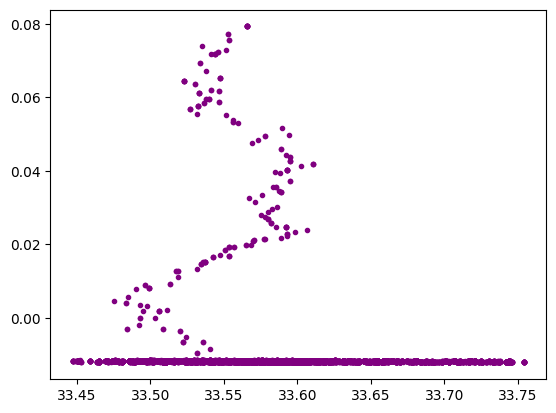

In [159]:
cad = montecarlo(x, y, N, sigma_b, sigma_m, paso_i, limits)
plt.scatter(cad[:,1], cad[:,0], s = None, marker='.', color='purple');

Text(0.5, 0, 'Paso')

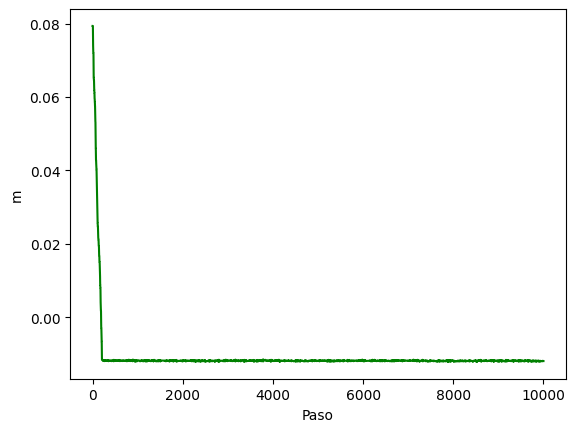

In [160]:
plt.plot(cad[:,0], color='green')
plt.ylabel('m')
plt.xlabel('Paso')

Text(0.5, 0, 'Pasos')

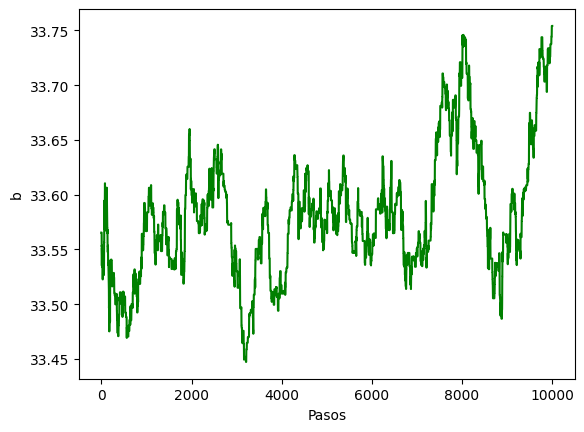

In [161]:
plt.plot(cad[:,1], color='green')
plt.ylabel('b')
plt.xlabel('Pasos')

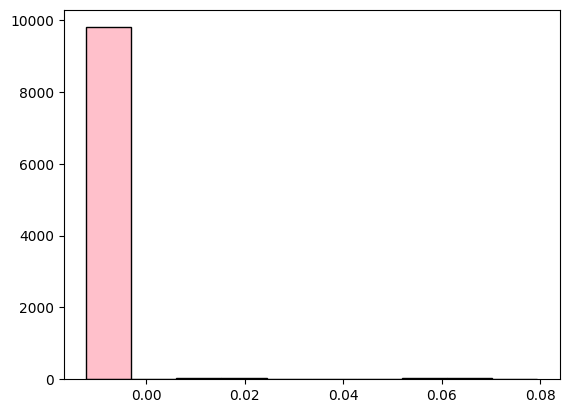

In [162]:
plt.hist(cad[:,0], color='pink', edgecolor='black');

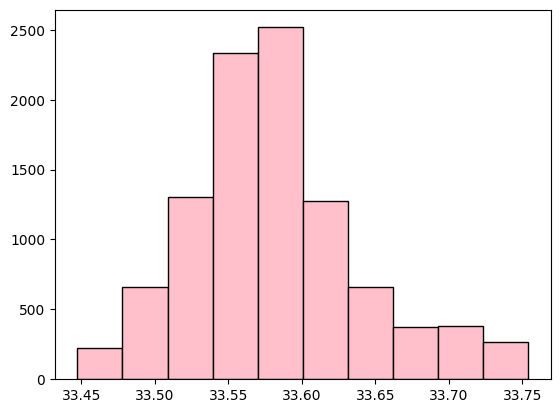

In [163]:
plt.hist(cad[:, 1], color='pink', edgecolor='black');

Ahora, con los datos normalizados

In [164]:
limits = [-.8, 0, 5, 13]
sigma_m = .01
sigma_b = .2
paso_i = [np.random.uniform(limits[0], limits[1]), np.random.uniform(limits[2], limits[3])]
N = 20000

In [165]:
cadena = montecarlo(x_nor, y, N, sigma_b, sigma_m, paso_i, limits)

Fraccion de Rechazados 0.30833458327083646
Fraccion de Aceptados 0.6916154192290386


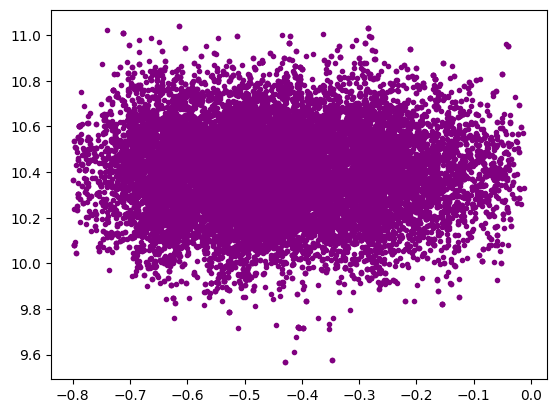

In [166]:
plt.scatter(cadena[:,0], cadena[:,1], s = None, marker='.', color='purple')

In [168]:
# Calculamos las w con los valores promedios de la cadena de datos aceptados
w1 = np.mean(cadena[:,0][1000:])
w0 = np.mean(cadena[:,1][1000:])
print(np.mean(cadena[:,0][1000:]), np.mean(cadena[:,1][1000:]))

-0.4344013123863943 10.395998981319686


Text(0.5, 0, 'pasos')

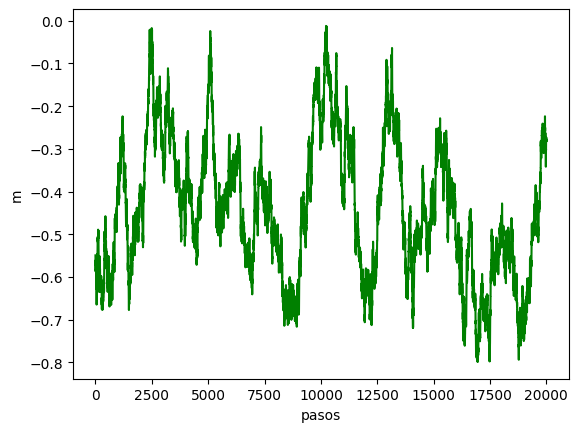

In [169]:
plt.plot(cadena[:,0], color='green')
plt.ylabel('m')
plt.xlabel('pasos')

Text(0.5, 0, 'Pasos')

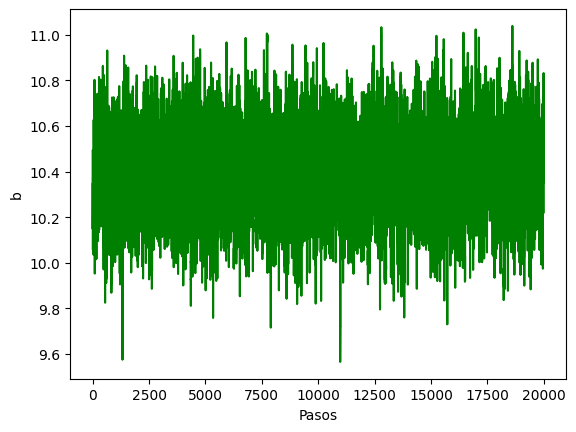

In [170]:
plt.plot(cadena[:,1], color='green')
plt.ylabel('b')
plt.xlabel('Pasos')

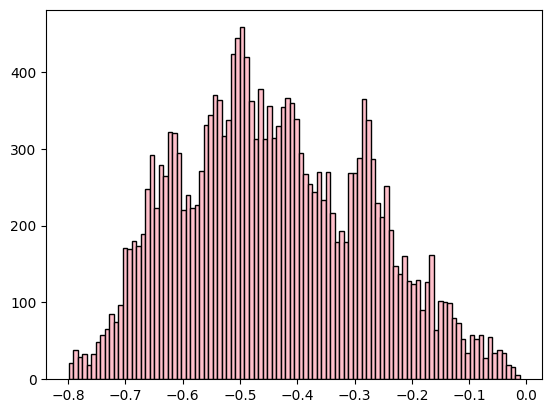

In [172]:
plt.hist(cadena[:,0], bins=100,color='pink', edgecolor='black');

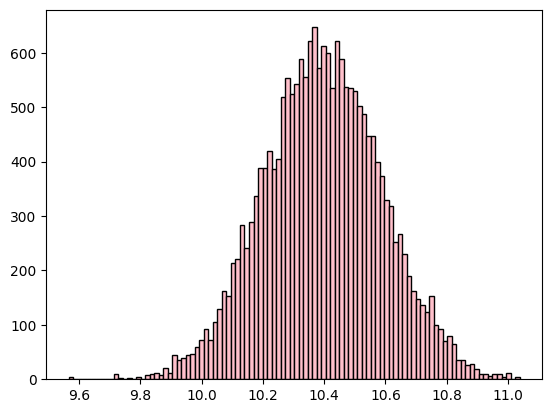

In [174]:
plt.hist(cadena[:,1], bins = 100, color='pink', edgecolor='black');

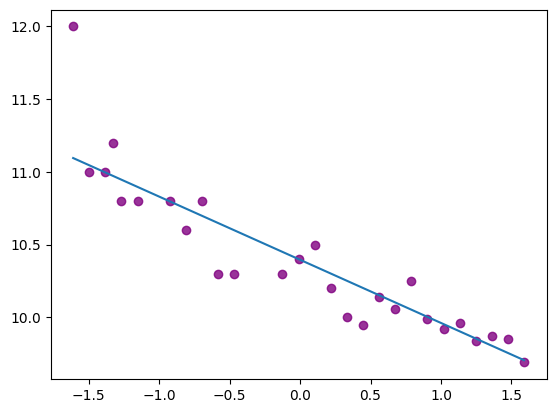

In [176]:
#Graficamos los datos normalizados con su ajuste del modelo lineal
plt.scatter(x_nor,y, color='purple', alpha=0.8)
plt.plot(x_nor, model(x_nor, [w1, w0]))

# Gelman-Rubin Diagnostic
Para aplicar este diagnóstico, creamos 5 cadenas.

In [177]:
chains = []
vars = []
promedios = []
for i in range(5):  # Generamos las 5 cadenas con el método de montecarlo, cada una con valores diferentes
  cadena = montecarlo(x_nor, y, N, sigma_b, sigma_m, paso_i, limits)
  chains.append(cadena)
  varm = np.var(cadena[:,0][1000:])
  varb = np.var(cadena[:,1][1000:])

  m_prom = np.mean(cadena[:,0][1000:])
  b_prom = np.mean(cadena[:,1][1000:])

  promedios.append([m_prom, b_prom])  #Guardamos los valores promedio
  vars.append([varm, varb])

Fraccion de Rechazados 0.3096845157742113
Fraccion de Aceptados 0.6902654867256637
Fraccion de Rechazados 0.30593470326483674
Fraccion de Aceptados 0.6940152992350382
Fraccion de Rechazados 0.30693465326733665
Fraccion de Aceptados 0.6930153492325384
Fraccion de Rechazados 0.31373431328433576
Fraccion de Aceptados 0.6862156892155392
Fraccion de Rechazados 0.3094345282735863
Fraccion de Aceptados 0.6905154742262887


In [179]:
# Calculamos los promedios de m y b, así como sus varianzas para aplicar el método de diagnóstico
promedios = np.array(promedios)
vars = np.array(vars)

m_proms = promedios[:,0]
b_proms = promedios[:,1]

m_varianza = np.mean(vars[:,0])
b_varianza = np.mean(vars[:,1])

m_prom = np.mean(m_proms)
b_prom = np.mean(b_proms)

B_b = 1/4*np.sum((b_proms - b_prom)**2)
B_m = 1/4*np.sum((m_proms- m_prom)**2)

In [180]:
sigma_squared_m = (20001 - 1)/(20001) * m_varianza + B_m
sigma_squared_b = (20001 - 1)/(20001) * b_varianza + B_b

In [181]:
R_m = np.sqrt(sigma_squared_m/m_varianza)
R_b = np.sqrt(sigma_squared_b/b_varianza)

print('R_m: ', R_m)
print('R_b: ', R_b)

R_m:  1.1235865136612118
R_b:  1.0004382768921465


In [182]:
!pip install corner

In [183]:
import corner

In [185]:
limits = [-.8, 0, 5, 13]
sigma_m = .01
sigma_b = .2
paso_i = [np.random.uniform(limits[0], limits[1]), np.random.uniform(limits[2], limits[3])]
N = 50000

In [186]:
cadena = montecarlo(x_nor, y, N, sigma_b, sigma_m, paso_i, limits)

Fraccion de Rechazados 0.30613387732245356
Fraccion de Aceptados 0.6938461230775385


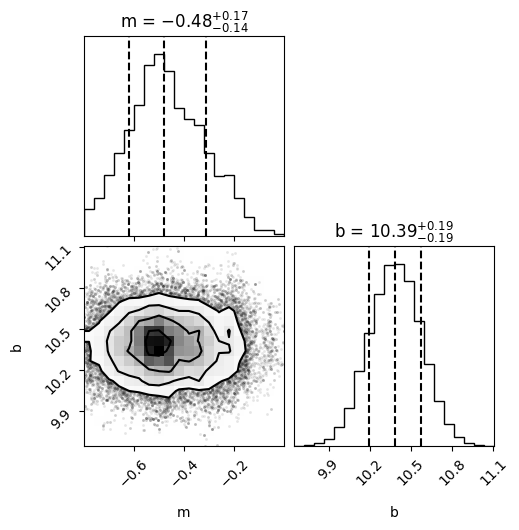

In [187]:
figure = corner.corner(cadena, labels=['m', 'b', 'm'], fontsize =12, quantiles=[0.16, .5, .84], show_titles=True)